In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor as RFR, HistGradientBoostingRegressor
from  sklearn.utils import resample
import scipy.stats as st
import math as m
from tqdm import tqdm
# from lightgbm import RandomForestRegres

In [2]:
data = pd.read_csv('insurance.csv', sep=',')
data_train = data.sample(frac=0.9)
data_validate = data.loc[~data.index.isin(data_train.index)]
data_train

,age,sex,bmi,children,smoker,region,charges
483,51,female,39.500,1,no,southwest,9880.06800
1081,32,male,27.835,1,no,northwest,4454.40265
1238,37,male,22.705,3,no,northeast,6985.50695
265,46,male,42.350,3,yes,southeast,46151.12450
560,46,female,19.950,2,no,northwest,9193.83850
...,...,...,...,...,...,...,...
374,20,male,33.330,0,no,southeast,1391.52870
623,18,male,33.535,0,yes,northeast,34617.84065
57,18,male,31.680,2,yes,southeast,34303.16720
130,59,female,26.505,0,no,northeast,12815.44495


# **L1 CONFIDENCE INTERVAL 95**

**CREATE COLUMN TRANSFORMER**

In [3]:
col_trans_l1 = ColumnTransformer([
    ('scaller', StandardScaler(), ['age', 'bmi', 'children']),
    ('hot_encode', OneHotEncoder(handle_unknown='ignore', drop='first'), ['sex', 'smoker', 'region']),
], remainder='passthrough')

**CREATE PIPE**

In [4]:
pipe_l1 = Pipeline([
    ('col_trans_l1', col_trans_l1), 
    ('poly', PolynomialFeatures(degree=4, include_bias=False)), 
    ('lasso', Lasso(alpha=69.56552173913043))
])

In [5]:
pipe_l1.fit(data_train.loc[:, ~data_train.columns.isin(['charges'])], data_train['charges'])

Pipeline(steps=[('col_trans_l1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaller', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('hot_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('poly', PolynomialFeatures(degree=4, include_bias=False)),
                ('lasso', Lasso(alpha=69.56552173913043))])

**L1 RESULTS- BEST MEAN SCORE**

In [6]:
def btstrap_cv_score(data, pipe):
    res = np.zeros((1000,), dtype=int)
    for i in tqdm(range(1000)):
        resampled_data = data.sample(frac=0.7)
        res[i] = -np.mean(cross_validate(pipe,
                                         resampled_data.loc[:, ~resampled_data.columns.isin(['charges'])],
                                         resampled_data['charges'],
                                         scoring=('neg_mean_absolute_error',))['test_neg_mean_absolute_error'])
    return res

In [7]:
l1_res = btstrap_cv_score(data_train, pipe_l1)

  3%|██                                                                              | 26/1000 [00:03<01:53,  8.61it/s]D:\Programming\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.729e+07, tolerance: 1.024e+07
  model = cd_fast.enet_coordinate_descent(
 23%|██████████████████▏                                                            | 230/1000 [00:31<01:47,  7.13it/s]D:\Programming\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e+07, tolerance: 1.142e+07
  model = cd_fast.enet_coordinate_descent(
 26%|████████████████████▌                                  

In [8]:
l1_res

array([2981, 3010, 2899, 2743, 2916, 2913, 2895, 2852, 3013, 2994, 2889,
       2749, 2787, 3129, 2890, 2749, 2944, 2829, 2906, 2896, 2986, 2826,
       2594, 2915, 2823, 2730, 2787, 2905, 2905, 3005, 2955, 2834, 2973,
       2783, 2824, 2825, 2932, 2844, 2761, 3067, 2756, 3021, 2837, 3038,
       3076, 2767, 3042, 2707, 2986, 2871, 3072, 2946, 2991, 3132, 2884,
       3010, 2878, 2842, 2881, 2920, 2857, 2883, 2936, 3108, 2728, 3029,
       2949, 2775, 2916, 3018, 2918, 2700, 2685, 2967, 2947, 2926, 2959,
       2846, 3129, 2794, 2870, 2926, 3132, 2883, 2760, 2815, 3013, 3074,
       2886, 2727, 2841, 2839, 3147, 2847, 2987, 2809, 2876, 3043, 2889,
       3055, 2839, 2847, 2992, 2915, 2929, 3107, 2870, 3010, 2851, 2802,
       2613, 3022, 2981, 2918, 3158, 2974, 2884, 3344, 3093, 3121, 2956,
       2901, 2787, 3085, 2934, 2838, 3116, 2820, 2946, 3006, 3063, 2940,
       2630, 2872, 2823, 2866, 3050, 3025, 2944, 2940, 3011, 2958, 2907,
       2883, 2907, 2929, 2906, 2744, 2600, 2779, 29

In [9]:
l1_res_df = pd.DataFrame(data=l1_res, columns=['means'])

In [10]:
print(np.mean(l1_res), np.std(l1_res, ddof=1), len(l1_res) ** 0.5)

2926.814 142.4239586164771 31.622776601683793


**CALCULATE 95% CONFIDENSE INTERVAL**

In [11]:
def conf_interv(array, conf_lvl):
    return (np.mean(array) - conf_lvl * (np.std(array, ddof=1) / m.sqrt(array.shape[0])), 
            np.mean(array) + conf_lvl * (np.std(array, ddof=1) / m.sqrt(array.shape[0])))

In [12]:
conf_interv(l1_res, 1.96)

(2917.9864715889294, 2935.6415284110703)

**BUILD HISTOGRAM**

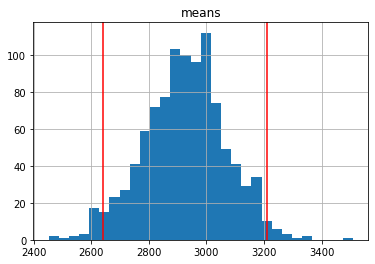

In [13]:
fig = l1_res_df.hist(bins=30)
fig[0][0].axvline(x=np.mean(l1_res) - 2 * np.std(l1_res, ddof=1), color='red')
fig[0][0].axvline(x=np.mean(l1_res) + 2 * np.std(l1_res, ddof=1), color='red')

**BUILD PROBABILITY DENSITY FUNCTION**

In [14]:
st.t.interval(alpha=0.95, df=len(l1_res)-1, loc=np.mean(l1_res), scale=st.sem(l1_res), )

(2917.975926020216, 2935.652073979784)

# **L2 95 CONFIDENCE INTERVAL**

**LETS CREATE PIPE (WE CAN USE THE SAME COLUMN TRANSFORMER)**

In [15]:
col_trans_l2 = col_trans_l1

In [16]:
pipe_l2 = Pipeline([
    ('col_trans_l2', col_trans_l2), 
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
    ('ridge', Ridge(alpha=1e-05))
])

**CALCULATE RESULTS**

In [17]:
l2_res = btstrap_cv_score(data_train, pipe_l2)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.33it/s]


In [18]:
l2_res_df = pd.DataFrame(data=l2_res, columns=['means'])

In [19]:
st.t.interval(alpha=0.95, df=len(l2_res)-1, loc=np.mean(l2_res), scale=st.sem(l2_res))

(2940.5468479747146, 2956.161152025285)

**BUILD HISTOGRAM**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002143D981B80>]],
      dtype=object)

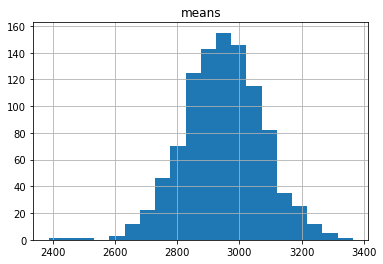

In [20]:
l2_res_df.hist(bins=20)

# **DECISION TREE BOOTSTRAP**

**CREATE COLLUMN TRANSFORMER**

In [21]:
bintree_trans = ColumnTransformer([
    ('encode_ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['sex', 'smoker', 'region']),
], remainder='passthrough')

**CREATE PIPELINE**

In [22]:
pipe_bintree = Pipeline([
    ('bintree_trans', bintree_trans), 
    ('bintree', DecisionTreeRegressor(max_depth=5, min_samples_leaf=11))
])

**CALCULATE RESULTS**

In [23]:
bintree_res = btstrap_cv_score(data_train, pipe_bintree)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.19it/s]


In [24]:
bintree_res

array([2406, 2694, 2560, 2825, 2802, 2723, 2663, 2863, 2548, 2737, 2628,
       2745, 2512, 2563, 2472, 2579, 2685, 2666, 2686, 2451, 2736, 2746,
       2609, 2797, 2671, 2635, 2606, 2820, 2688, 2729, 2553, 2650, 2892,
       2825, 2850, 2678, 2704, 2682, 2981, 2802, 2792, 2724, 2582, 2663,
       2942, 2561, 2746, 2665, 2626, 2688, 2757, 2710, 2585, 2490, 2696,
       2546, 2646, 2599, 2768, 2796, 2574, 2909, 2731, 2814, 2644, 2675,
       2648, 2608, 2911, 2514, 2709, 2693, 2512, 2893, 2573, 2511, 2590,
       2718, 2655, 2741, 2806, 2669, 2660, 2657, 2807, 2792, 2705, 2567,
       2709, 2632, 2803, 2505, 2814, 2700, 2801, 2753, 2735, 2723, 2517,
       2738, 2745, 2558, 2758, 2638, 2815, 2614, 2665, 2882, 2891, 2711,
       2828, 2649, 2786, 2557, 2731, 2701, 2955, 2841, 2966, 2676, 2620,
       2745, 2687, 2344, 2683, 2705, 2455, 2517, 2744, 2412, 2588, 2991,
       2615, 2553, 2725, 2936, 2695, 2811, 2604, 2757, 2486, 2699, 2509,
       2699, 2653, 2672, 2603, 2709, 2643, 2609, 27

In [25]:
bintree_df = pd.DataFrame(data=bintree_res, columns=['means'])

**BUILD HISTOGRAM**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002143DA4EA90>]],
      dtype=object)

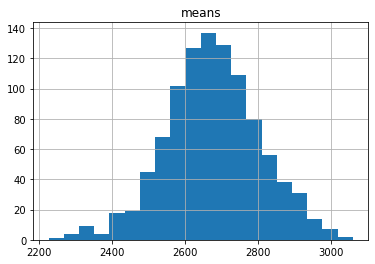

In [26]:
bintree_df.hist(bins=20)

In [27]:
st.t.interval(alpha=0.95, df=len(bintree_res)-1, loc=np.mean(bintree_res), scale=st.sem(bintree_res), )

(2668.614233020128, 2684.651766979872)

# **GRADIENT BOOST**

**CREATE TRANSFORMER**

In [28]:
grad_boost_trans = ColumnTransformer([
    ('encode_ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['sex', 'smoker', 'region']),
], remainder='passthrough')

**BUILD PIPELINE**

In [45]:
pipe_grad_boost = Pipeline([
    ('grad_boost_trans', grad_boost_trans), 
    ('grad_boost', HistGradientBoostingRegressor())
])

In [49]:
parameter_gradboost = {
    'grad_boost__max_depth': np.linspace(2, 20, 19).astype(int),
    'grad_boost__min_samples_leaf': np.linspace(2, 150, 146).astype(int),
    'grad_boost__learning_rate': np.linspace(0.0001, 0.1, 30)
}

In [30]:
gradboost_res = btstrap_cv_score(data_train, pipe_grad_boost)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [22:30<00:00,  1.35s/it]


In [31]:
gradboost_res_df = pd.DataFrame(data=gradboost_res, columns=['means'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002143D97BBE0>]],
      dtype=object)

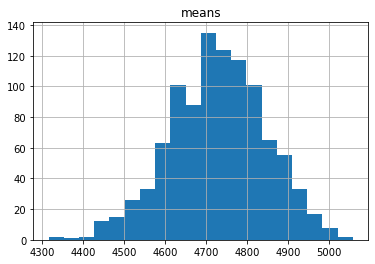

In [32]:
gradboost_res_df.hist(bins=20)

In [50]:
grid_gradboost = GridSearchCV(pipe_grad_boost, parameter_gradboost, scoring='neg_mean_absolute_error', n_jobs=8, verbose=1)

In [51]:
grid_gradboost.fit(data_train.loc[:, ~data_train.columns.isin(['charges'])], data_train['charges'])

Fitting 5 folds for each of 83220 candidates, totalling 416100 fits


GridSearchCV(estimator=Pipeline(steps=[('grad_boost_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encode_ord',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('grad_boost',
                                        HistGradientBoostingRegressor())]),
             n_jobs=8,
             param_grid={'grad_boost__learning_rate': array([0.0001    , 0.00354483,...
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 150])},
             scoring='neg_mean_absolute_error', verbose=1)

In [52]:
grid_gradboost.best_score_

-2437.2914816229486

In [53]:
grid_gradboost.best_params_

{'grad_boost__learning_rate': 0.05866206896551725,
 'grad_boost__max_depth': 3,
 'grad_boost__min_samples_leaf': 9}